In [1]:
import glob
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
# data prep and model-tuning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import SelectFromModel
from skopt import BayesSearchCV
from sklearn.metrics import (make_scorer, cohen_kappa_score, 
                             precision_recall_curve, confusion_matrix, 
                             plot_precision_recall_curve, precision_score, 
                             recall_score, f1_score)

# types of models we'll fit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# for saving things
import pickle
# skopt generates warnings if the same parameter set is sampled again
import warnings

In [3]:
from imblearn.metrics import classification_report_imbalanced, sensitivity_specificity_support

## Our Data

In [4]:
DATA = '../data/processed/monthly_species_training.csv'
df = pd.read_csv(DATA)
print('{:,d} samples'.format(len(df)))
print('Columns:', df.columns.values)

8,906 samples
Columns: ['lat' 'lon' 'orig_id' 'uuid' 'source' 'meas_yr' 'ecoregion3' 'agency'
 'plot_size_ac' 'year' 'tmax01' 'tmax02' 'tmax03' 'tmax04' 'tmax05'
 'tmax06' 'tmax07' 'tmax08' 'tmax09' 'tmax10' 'tmax11' 'tmax12' 'tmin01'
 'tmin02' 'tmin03' 'tmin04' 'tmin05' 'tmin06' 'tmin07' 'tmin08' 'tmin09'
 'tmin10' 'tmin11' 'tmin12' 'tave01' 'tave02' 'tave03' 'tave04' 'tave05'
 'tave06' 'tave07' 'tave08' 'tave09' 'tave10' 'tave11' 'tave12' 'ppt01'
 'ppt02' 'ppt03' 'ppt04' 'ppt05' 'ppt06' 'ppt07' 'ppt08' 'ppt09' 'ppt10'
 'ppt11' 'ppt12' 'dd_0_01' 'dd_0_02' 'dd_0_03' 'dd_0_04' 'dd_0_05'
 'dd_0_06' 'dd_0_07' 'dd_0_08' 'dd_0_09' 'dd_0_10' 'dd_0_11' 'dd_0_12'
 'dd5_01' 'dd5_02' 'dd5_03' 'dd5_04' 'dd5_05' 'dd5_06' 'dd5_07' 'dd5_08'
 'dd5_09' 'dd5_10' 'dd5_11' 'dd5_12' 'dd_18_01' 'dd_18_02' 'dd_18_03'
 'dd_18_04' 'dd_18_05' 'dd_18_06' 'dd_18_07' 'dd_18_08' 'dd_18_09'
 'dd_18_10' 'dd_18_11' 'dd_18_12' 'dd18_01' 'dd18_02' 'dd18_03' 'dd18_04'
 'dd18_05' 'dd18_06' 'dd18_07' 'dd18_08' 'dd18_09' '

In [5]:
# filter out some outliers (detected based on major difference between lidar height and field-measured height)
outliers = pd.read_csv('../data/interim/outlier_uuids.csv')
outliers.head()

,outlier_uuid
0,01ef37b1-899f-49c3-9031-127995694ea0
1,0228e3ed-e7a0-4053-ac38-4abe9c84e214
2,02e702cb-65c1-4c95-a271-8a815419965f
3,05bd7e12-fd98-4358-83bc-cc2c0f9dde83
4,0636e7b4-f206-420c-8b62-d9e72c0295fa


In [6]:
df = df.loc[~df.uuid.isin(outliers.outlier_uuid)].reset_index(drop=True)

In [7]:
# df['year_diff'] = abs(df['year'] - df['meas_yr'])
# df = df.loc[df.groupby(by=['uuid'])['year_diff'].idxmin()]
# df.info()

The different types of predictor variables we will use to predict forest composition, including climate, soil, and satellite-derived attributes.

In [8]:
# calculate cumulative degree days above 5C each year
dd5_cols = [col for col in df.columns if col.startswith('dd5')]
dd5_cum_cols = [col + '_cum' for col in dd5_cols]
df[dd5_cum_cols] = df[dd5_cols].cumsum(axis=1)

In [9]:
# calculate cumulative degree days below 0C each year
dd_0_cols = ['dd_0_10', 'dd_0_11', 'dd_0_12', 'dd_0_01', 'dd_0_02', 'dd_0_03']
dd_0_cum_cols = [col + '_cum' for col in dd_0_cols]
df[dd_0_cum_cols] = df[dd_0_cols].cumsum(axis=1)

In [10]:
# calculate cumulative degree days above 5C each year
dd5_cols = [col for col in df.columns if col.startswith('dd5')]
dd5_cum_cols = [col + '_cum' for col in dd5_cols]
df[dd5_cum_cols] = df[dd5_cols].cumsum(axis=1)

# calculate cumulative degree days below 0C each year
dd_0_cols = ['dd_0_10', 'dd_0_11', 'dd_0_12', 'dd_0_01', 'dd_0_02', 'dd_0_03']
dd_0_cum_cols = [col + '_cum' for col in dd_0_cols]
df[dd_0_cum_cols] = df[dd_0_cols].cumsum(axis=1)

# calculate cumulative degree days above 5C each year
cmd_cols = [col for col in df.columns if col.startswith('cmd')]
cmd_cum_cols = [col + '_cum' for col in cmd_cols]
df[cmd_cum_cols] = df[cmd_cols].cumsum(axis=1)

In [11]:
# calculate  few additional indices for sentinel-2 and landsat
for season in ['LEAFON', 'LEAFOFF']:
    for sensor in ['L8']:
        R, G, B = f'{sensor}_R_{season}', f'{sensor}_G_{season}', f'{sensor}_B_{season}'
        NIR, SWIR1, SWIR2 =  f'{sensor}_NIR_{season}', f'{sensor}_SWIR1_{season}', f'{sensor}_SWIR2_{season}'

        NDVI = f'{sensor}_NDVI_{season}'
        df[NDVI] = (df[NIR] - df[R])/(df[NIR] + df[R])

        ENDVI = f'{sensor}_ENDVI_{season}'
        df[NDVI] = (df[NIR] + df[G] - 2*df[B])/(df[NIR] + df[G] + 2*df[B])

        SAVI = f'{sensor}_SAVI_{season}'
        df[SAVI] = 1.5*(df[NIR] - df[R])/(df[NIR] + df[R] + 0.5)
        
        BRIGHTNESS = f'{sensor}_BRIGHTNESS_{season}'
        df[BRIGHTNESS] = 0.3029*df[B] + 0.2786*df[G] + 0.4733*df[R] + 0.5599*df[NIR] + 0.508*df[SWIR1] + 0.1872*df[SWIR2]
        
        GREENNESS = f'{sensor}_GREENNESS_{season}'
        df[GREENNESS] = -0.2941*df[B] + -0.243*df[G] + -0.5424*df[R] + 0.7276*df[NIR] + 0.0713*df[SWIR1] + -0.1608*df[SWIR2]
        
        WETNESS = f'{sensor}_WETNESS_{season}'
        df[WETNESS] = 0.1511*df[B] + 0.1973*df[G] + 0.3283*df[R] + 0.3407*df[NIR] + -0.7117*df[SWIR1] + -0.4559*df[SWIR2]
for sensor in ['L8']:
    bands = np.unique([col.split(f'{sensor}_')[1].split('_')[0] for col in df.columns if col.startswith(sensor)])
    for band in bands:
        col = f'{sensor}_d{band}'
        df[col] = df[f'{sensor}_{band}_LEAFON'] - df[f'{sensor}_{band}_LEAFOFF']

In [12]:
# for using monthly climate attributes
CLIM_COLS = [
    # cumulative growing degree days above 5C in spring
    'dd5_03_cum', 'dd5_04_cum', 'dd5_05_cum',  
    
    # cumulative chilling degree days below 0C in late fall and winter months
    'dd_0_11_cum', 'dd_0_12_cum', 'dd_0_01_cum', 'dd_0_02_cum', 'dd_0_03_cum', 
    
    # cumulative climatic moisture deficit during growing season
    'cmd05_cum', 'cmd06_cum', 'cmd07_cum', 'cmd08_cum', 
]


SOIL_COLS = ['bulk_dens', 'soil_depth', 'pct_clay_surf', 'pct_rock_surf', 'pct_sand_surf']

LANDSAT_COLS = [
    'L8_R_LEAFOFF', 'L8_G_LEAFOFF', 'L8_B_LEAFOFF', 
    'L8_NIR_LEAFOFF', 'L8_SWIR1_LEAFOFF', 'L8_SWIR2_LEAFOFF', 
    'L8_NDVI_LEAFOFF', 'L8_SAVI_LEAFOFF', 'L8_BRIGHTNESS_LEAFOFF', 'L8_GREENNESS_LEAFOFF', 'L8_WETNESS_LEAFOFF',
    'L8_R_LEAFON', 'L8_G_LEAFON', 'L8_B_LEAFON', 
    'L8_NIR_LEAFON', 'L8_SWIR1_LEAFON', 'L8_SWIR2_LEAFON',
    'L8_NDVI_LEAFON', 'L8_SAVI_LEAFON', 'L8_BRIGHTNESS_LEAFON', 'L8_GREENNESS_LEAFON', 'L8_WETNESS_LEAFON',
    'L8_dR', 'L8_dG', 'L8_dB', 
    'L8_dNIR', 'L8_dSWIR1', 'L8_dSWIR2',
    'L8_dNDVI', 'L8_dSAVI', 'L8_dBRIGHTNESS', 'L8_dGREENNESS', 'L8_dWETNESS'
]

MODIS_COLS = ['dormancy', 'evi_amplitude', 'evi_area', 'evi_minimum',
              'greenup', 'maturity', 'midgreendown', 'midgreenup', 
              'peak',
#              'numcycles'
             ]

In [13]:
RANDOM_STATE = 19831207

## Selecting initial features and targets
This is the first step in determining what features we want to use, and what we want to predict. Later, we can still apply some procedures to choose a subset of these features to make simpler models.

Now we can apply this threshold to all the species-group-level basal areas for the plots to create a binary presence/absence classification for each species group on each plot. 

In [14]:
BA_COLS = ['TRUE_FIR', 'OTHER_HARDWOOD', 'MAPLE', 'OAK', 'DOUGLAS_FIR', 
           'SPRUCE', 'CEDAR', 'PONDEROSA_PINE', 'OTHER_SOFTWOOD', 
           'LODGEPOLE_PINE', 'HEMLOCK', 'RED_ALDER', 'TANOAK', 'JUNIPER',
           'LARCH']

pres_cols = [x + '_pres' for x in BA_COLS]
spp_presence = (df[BA_COLS].values.reshape(-1,1) > 0).reshape(df[BA_COLS].shape)*1
spp_presence = pd.DataFrame(data=spp_presence, columns=pres_cols)

We'll use the following classification of abundance for each species:

| label | description | basal area |  
| :--: | :--: | :--: |
| 0 | absent | 0% |  
| 1 | present | (0-33%] |  
| 2 | abundant | (33-66%] |
| 3 | dominant | (66-100%] |

In [15]:
ba_prop = df[BA_COLS].divide(df[BA_COLS].sum(axis=1) + 1e-9, axis=0)
prop_cols = [x + '_prop' for x in BA_COLS]
ba_prop.columns = prop_cols

SW_SPP = ['TRUE_FIR', 'DOUGLAS_FIR', 'SPRUCE', 'CEDAR', 
          'PONDEROSA_PINE', 'OTHER_SOFTWOOD', 'LODGEPOLE_PINE', 
          'HEMLOCK', 'JUNIPER', 'LARCH']
SW_PROP_COLS = [spp+'_prop' for spp in SW_SPP]
HW_SPP = ['OTHER_HARDWOOD','MAPLE', 'OAK', 'RED_ALDER', 'TANOAK']
HW_PROP_COLS = [spp+'_prop' for spp in HW_SPP]

ba_prop['ALL_HARDWOOD_prop'] = ba_prop[HW_PROP_COLS].sum(axis=1)
ba_prop['ALL_SOFTWOOD_prop'] = ba_prop[SW_PROP_COLS].sum(axis=1)
# prop_cols.extend(['ALL_HARDWOOD_prop', 'ALL_SOFTWOOD_prop'])

abund_cols = [x + '_abund' for x in BA_COLS]
# abund_cols.extend(['ALL_HARDWOOD_abund', 'ALL_SOFTWOOD_abund'])

spp_abund = pd.DataFrame(data=np.digitize(ba_prop[prop_cols].values, [0,1/3,2/3], right=True), 
                         index=ba_prop.index,
                         columns=abund_cols)

In [16]:
spp_abund['HARDWOOD_SOFTWOOD_abund'] = np.nan

# hardwood dominance, no softwood presence
spp_abund.loc[(ba_prop['ALL_HARDWOOD_prop'] >= 0.66) & 
              (ba_prop['ALL_SOFTWOOD_prop'] < 0.05),
              'HARDWOOD_SOFTWOOD_abund'] = -2

# hardwood dominance, softwood presence
spp_abund.loc[(ba_prop['ALL_HARDWOOD_prop'] >= 0.66) & 
              (ba_prop['ALL_SOFTWOOD_prop'] >= 0.05),
              'HARDWOOD_SOFTWOOD_abund'] = -1

# no basal area recorded, nonstocked
spp_abund.loc[np.isclose(ba_prop['ALL_HARDWOOD_prop'],0) & 
              np.isclose(ba_prop['ALL_SOFTWOOD_prop'],0),
              'HARDWOOD_SOFTWOOD_abund'] = -9998

# softwood dominance, hardwood presence
spp_abund.loc[(ba_prop['ALL_SOFTWOOD_prop'] >= 0.66) & 
              (ba_prop['ALL_HARDWOOD_prop'] >= 0.05),
              'HARDWOOD_SOFTWOOD_abund'] = 1

# softwood dominance, no hardwood presence
spp_abund.loc[(ba_prop['ALL_SOFTWOOD_prop'] >= 0.66) & 
              (ba_prop['ALL_HARDWOOD_prop'] < 0.05),
              'HARDWOOD_SOFTWOOD_abund'] = 2

# softwood and hardwood equal at 40-50%
spp_abund.loc[(ba_prop['ALL_SOFTWOOD_prop'] >= 0.33)&
              (ba_prop['ALL_HARDWOOD_prop'] >= 0.33)& 
              (ba_prop['ALL_SOFTWOOD_prop'] >= 0),
              'HARDWOOD_SOFTWOOD_abund'] = 0

spp_abund['HARDWOOD_SOFTWOOD_abund'] = spp_abund['HARDWOOD_SOFTWOOD_abund'].astype(int)

In [17]:
spp_df = pd.concat([ba_prop, spp_abund], axis=1)
spp_df.head()

,TRUE_FIR_prop,OTHER_HARDWOOD_prop,MAPLE_prop,OAK_prop,DOUGLAS_FIR_prop,SPRUCE_prop,CEDAR_prop,PONDEROSA_PINE_prop,OTHER_SOFTWOOD_prop,LODGEPOLE_PINE_prop,...,CEDAR_abund,PONDEROSA_PINE_abund,OTHER_SOFTWOOD_abund,LODGEPOLE_PINE_abund,HEMLOCK_abund,RED_ALDER_abund,TANOAK_abund,JUNIPER_abund,LARCH_abund,HARDWOOD_SOFTWOOD_abund
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096639,0.000000,...,0,0,1,0,3,0,0,0,0,2
1,0.687861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098266,0.005780,...,0,0,1,1,1,0,0,0,0,2
2,0.688235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.005882,...,0,0,1,1,1,0,0,0,0,2
3,0.690058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099415,0.005848,...,0,0,1,1,1,0,0,0,0,2
4,0.686047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098837,0.005814,...,0,0,1,1,1,0,0,0,0,2


In [18]:
# merge these presence and abundance classes into the dataframe
df = pd.concat([df, spp_df], axis=1)
df.head()

,lat,lon,orig_id,uuid,source,meas_yr,ecoregion3,agency,plot_size_ac,year,...,CEDAR_abund,PONDEROSA_PINE_abund,OTHER_SOFTWOOD_abund,LODGEPOLE_PINE_abund,HEMLOCK_abund,RED_ALDER_abund,TANOAK_abund,JUNIPER_abund,LARCH_abund,HARDWOOD_SOFTWOOD_abund
0,43.631354,-121.946826,060105045220239,df4c7f9d-666a-4543-bf08-b6e849bb3bff,USFS-BLUE-MOUNTAINS,2015,cascades,USFS,0.25,2016,...,0,0,1,0,3,0,0,0,0,2
1,43.926278,-121.822672,060105053830240,482d6afb-a0df-4114-a199-193f2907760b,USFS-BLUE-MOUNTAINS,2015,cascades,USFS,0.25,2014,...,0,0,1,1,1,0,0,0,0,2
2,43.926278,-121.822672,060105053830240,482d6afb-a0df-4114-a199-193f2907760b,USFS-BLUE-MOUNTAINS,2015,cascades,USFS,0.25,2015,...,0,0,1,1,1,0,0,0,0,2
3,43.926278,-121.822672,060105053830240,482d6afb-a0df-4114-a199-193f2907760b,USFS-BLUE-MOUNTAINS,2015,cascades,USFS,0.25,2016,...,0,0,1,1,1,0,0,0,0,2
4,43.926278,-121.822672,060105053830240,482d6afb-a0df-4114-a199-193f2907760b,USFS-BLUE-MOUNTAINS,2015,cascades,USFS,0.25,2017,...,0,0,1,1,1,0,0,0,0,2


In [19]:
abund_cols

['TRUE_FIR_abund',
 'OTHER_HARDWOOD_abund',
 'MAPLE_abund',
 'OAK_abund',
 'DOUGLAS_FIR_abund',
 'SPRUCE_abund',
 'CEDAR_abund',
 'PONDEROSA_PINE_abund',
 'OTHER_SOFTWOOD_abund',
 'LODGEPOLE_PINE_abund',
 'HEMLOCK_abund',
 'RED_ALDER_abund',
 'TANOAK_abund',
 'JUNIPER_abund',
 'LARCH_abund']

In [20]:
# mark plots with canopy cover < 10%, QMD < 1", and TOPHT < 10' as non-stocked
df.loc[(df.total_cover < 10), 'HARDWOOD_SOFTWOOD_abund'] = -9998
df.loc[(df.qmd < 1), 'HARDWOOD_SOFTWOOD_abund'] = -9998
df.loc[(df.topht < 10), 'HARDWOOD_SOFTWOOD_abund'] = -9998

df = df.loc[df.HARDWOOD_SOFTWOOD_abund > -9998]
df['HARDWOOD_SOFTWOOD_abund'] =  df['HARDWOOD_SOFTWOOD_abund'] + 2

In [21]:
# plots with < 10% canopy cover, <1" QMD

In [22]:
X_COLS = LANDSAT_COLS + CLIM_COLS\
+ ['qmd', 'total_cover', 'topht']\
+ ['distance_to_water_m', 'lat', 'lon', 'aspect', 'elevation']
# + SOIL_COLS\
# + MODIS_COLS\

In [23]:
df = df.dropna(subset=X_COLS+abund_cols).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8002 entries, 0 to 8001
Columns: 373 entries, lat to HARDWOOD_SOFTWOOD_abund
dtypes: float64(192), int64(175), object(6)
memory usage: 22.8+ MB


## Split the data into training and testing sets
Since some plot_ids have multiple observations, we want all observations for each plot_id to fall entirely in train_set or entirely the training or testing sets because these samples are definitely not independent.

In [24]:
# create training and testing sets for each species group
train_sets = []
test_sets = []

# make sure each plot (uuid) only goes into either train or testing set
uuids = pd.unique(df['uuid'].values)
np.random.seed(RANDOM_STATE)
train0_test1 = np.random.choice((0,1), uuids.shape, p=(0.8,0.2))
train_test_assign = pd.DataFrame(np.dstack((uuids, train0_test1))[0], columns=['uuid', 'train0_test1'])
df_assigned = df.merge(train_test_assign, on='uuid')
    
train = df_assigned.loc[df_assigned['train0_test1'] == 0]
test = df_assigned.loc[df_assigned['train0_test1'] == 1]

## Standardize features
Scale all predictive features to have 0 mean and unit variance (subtracting mean, dividing by standard deviation).

In [25]:
X_train, X_test = train[X_COLS].copy(), test[X_COLS].copy()
x_scaler = StandardScaler()
x_scaler.fit(df[X_COLS])

X_train[X_COLS], X_test[X_COLS] = x_scaler.transform(X_train), x_scaler.transform(X_test)

Y_train, Y_test = train[spp_df.columns], test[spp_df.columns]

pickle.dump(x_scaler, 
            open('../models/composition/sklearn_tuned/x_scaler.pkl', 'wb'))

# Quick Look at Data
Be aware that the data are heavily skewed towards particularly widespread species like Douglas-fir, western hemlock, and red alder. There are far fewer examples, particularly of plots with other species where those species are abundant.

In [26]:
counts = df[abund_cols].apply(np.bincount, axis=0, minlength=4)
counts.columns = [col.split('_abund')[0] for col in counts.columns]
counts = counts.rename({0: 'absent', 1:'present', 2:'abundant', 3:'dominant'}, axis=0)
counts.T.sort_values(by='absent')\
.style.format('{:,d}')

,absent,present,abundant,dominant
DOUGLAS_FIR,"1,778","1,112","1,500","3,612"
HEMLOCK,"4,471","2,218",781,532
RED_ALDER,"5,785","1,564",328,325
OTHER_HARDWOOD,"6,057","1,612",202,131
CEDAR,"6,214","1,400",286,102
TRUE_FIR,"6,420",989,345,248
MAPLE,"7,153",770,61,18
PONDEROSA_PINE,"7,378",253,162,209
SPRUCE,"7,503",334,98,67
OTHER_SOFTWOOD,"7,637",350,4,11


In [27]:
counts = test[abund_cols].apply(np.bincount, axis=0, minlength=4)
counts.columns = [col.split('_abund')[0] for col in counts.columns]
counts = counts.rename({0: 'absent', 1:'present', 2:'abundant', 3:'dominant'}, axis=0)
counts.T.sort_values(by='absent')\
.style.format('{:,d}')

,absent,present,abundant,dominant
DOUGLAS_FIR,394,267,285,695
HEMLOCK,868,495,170,108
RED_ALDER,"1,141",337,81,82
OTHER_HARDWOOD,"1,250",305,59,27
CEDAR,"1,266",274,78,23
TRUE_FIR,"1,302",213,81,45
MAPLE,"1,474",150,10,7
PONDEROSA_PINE,"1,517",60,27,37
SPRUCE,"1,530",76,20,15
OTHER_SOFTWOOD,"1,559",82,0,0


In [28]:
df.groupby(by=['HARDWOOD_SOFTWOOD_abund'])['uuid'].count()

HARDWOOD_SOFTWOOD_abund
0     307
1     277
2     669
3    1928
4    4821
Name: uuid, dtype: int64

## Fit some models

In [3]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import CheckpointSaver
from skopt import dump, load

In [2]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor

MODEL_SEARCH_SPACES = {
    'rf': {
        'n_estimators': Integer(50, 5000, prior='uniform'),
        'max_depth': Integer(5, 32, prior='log-uniform'),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'min_samples_split': Integer(2, 20, prior='uniform'),
        'min_samples_leaf': Integer(1, 20, prior='uniform'),
    },
    'log': {
        'penalty': Categorical(['l1', 'l2', 'elasticnet', 'none']),
        'multi_class': Categorical(['ovr', 'multinomial']),
        'C': Real(1e-4, 1e4, prior='uniform'),
        'l1_ratio': Real(0, 1, prior='uniform'),
    },
    'svc':{
        'C': Real(1e-3, 1e2, prior='uniform'),
        'gamma': Real(1e-3, 1, prior='uniform'),
    },
    'knn': {
        'n_neighbors': Integer(1, 10, prior='uniform'),
        'weights': Categorical(['uniform', 'distance']), 
        'p': Integer(1, 100, prior='log-uniform')
    },
}

MODEL_TYPES = {
    'rf': RandomForestOrdinalClassifier(random_state=RANDOM_STATE,
                                        class_weight='balanced',
                                        n_jobs=-1),
    'rf_reg': RandomForestRegressor(random_state=RANDOM_STATE,
                                    n_jobs=-1),
    'bal_rf': BalancedRandomForestClassifier(random_state=RANDOM_STATE,
                                             class_weight='balanced',
                                             n_jobs=-1),
    'log': LogisticRegressionOrdinalClassifier(random_state=RANDOM_STATE,
                                               class_weight='balanced',
                                               solver='saga',
                                               n_jobs=-1),
    'svc': SVC(random_state=RANDOM_STATE,
               class_weight='balanced',
               kernel='rbf'),
    'kde': KDEClassifier(),
    'knn': KNeighborsOrdinalClassifier(n_jobs=-1)
}

NameError: name 'Integer' is not defined

In [32]:
groupkfold = GroupKFold(n_splits=3)
uuid_groups = df.reindex(X_train.index)['uuid']
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score, average_precision_score

# scorer = make_scorer(geometric_mean_score) 
# scorer = make_scorer(cohen_kappa_score, weights='linear')

def cohen_kappa_adjust(y_true, y_pred, labels=None, weights=None, sample_weight=None):
    if y_pred.dtype == 'float' and y_pred.max() <= 1.0: # regression model trained on proportions
        y_true = np.digitize(y_true, [0,1/3,2/3], right=True)
        y_pred = np.digitize(y_pred, [0,1/3,2/3], right=True)
    
    elif y_pred.dtype == 'float' and y_pred.max() > 1.0: # regression model trained on abundance integers
        y_true = y_true.round().astype(int)
        y_pred = y_pred.round().astype(int)
        
    return cohen_kappa_score(y_true, y_pred, labels, weights, sample_weight)



def tune_classifier(sp_name, model_type, samples_per_param=100, n_jobs=1, n_points=1):
    if model_type[-4:] == '_reg':
        y_train = Y_train[sp_name+'_prop']
    else:
        y_train = Y_train[sp_name+'_abund']
    
    model = MODEL_TYPES[model_type]
    search_space = {'model__{}'.format(key): value for (key, value) in MODEL_SEARCH_SPACES[model_type].items()}
    
    pipeline = Pipeline([# ('resampler', ADASYN(random_state=RANDOM_STATE, n_jobs=-1)),
                         ('model', model)])
    
    if sp_name == 'HARDWOOD_SOFTWOOD':
        LABELS = [0, 1, 2, 3, 4]
    else:
        LABELS = [0, 1, 2, 3]
    
    scorer = make_scorer(cohen_kappa_adjust, labels=LABELS, weights='linear')
    
    opt = BayesSearchCV(
        pipeline,
        search_space,
        n_iter=samples_per_param,
        random_state=RANDOM_STATE,
        cv=groupkfold,
        scoring=scorer,
        verbose=0,
        n_jobs=n_jobs,
        n_points=n_points,
    )
    
    # callback handler
    best_score = 0
    
    def on_step(optim_result):
        i = np.max(opt.cv_results_['rank_test_score'])
        if i % 10 == 1:
            print('\n@ sample iteration {}'.format(i), flush=True)
            
        score = opt.best_score_
        if min(opt.cv_results_['rank_test_score'][-n_points:]) == 1:
            print('','{:0.3f}'.format(score), end=' ', flush=True)
        else:
            print('.', end='', flush=True)
    
    SAVE_DIR = '../models/composition/sklearn_tuned/'
    check_pkl = '{}_{}_tuned_checkpoints.pkl'.format(sp_name, model_type)
    check_path = os.path.join(SAVE_DIR, check_pkl)
    checkpoint_saver = CheckpointSaver(check_path)

    print('Running {:,d} rounds of cross-validation.'.format(opt.total_iterations))
    print('Sampling {} parameters {} times each.'.format(len(search_space), samples_per_param))
    print('Displaying best cross-validation scores... ')
    
    with warnings.catch_warnings():  # don't issue warnings when we test the same parameter values
        warnings.filterwarnings("ignore", 
                                category=UserWarning) 
        
        # executes bayesian optimization
        _ = opt.fit(X_train, y_train, 
                    groups=uuid_groups, 
                    callback=[on_step, checkpoint_saver])
    
    opt_pkl = '{}_{}_tuned.pkl'.format(sp_name, model_type)
    opt_path = os.path.join(SAVE_DIR, opt_pkl)
    dump(opt, opt_path)
    print('Done. \nModel saved at {}\n'.format(opt_path))
    
    return opt

In [33]:
def print_classification_report(sp_name, model, 
                                target_names=['absent', 'present', 'abundant', 'dominant']):
    print(classification_report_imbalanced(
        Y_test[sp_name+'_abund'],
        model.predict(X_test),
        target_names=target_names))

To help interpret classification reports:
* `tp` is the number of true positives
* `fp` is the number of false positives, 
* `tn` is the number of true negatives 
* `fn` is the number of false negatives

**precision** is the ratio `tp / (tp + fp)`, or **the ability of the classifier not to label as positive a sample that is negative.** 

**recall** is the ratio `tp / (tp + fn)`, or **the ability of the classifier to find all the positive samples.**

**specificity** is the ratio `tn / (tn + fp)`, or **the ability of the classifier to find all the negative samples.**

In [34]:
def display_confusion(sp_name, model, 
                      labels=[0, 1, 2, 3],
                      display_labels=['Absent', 'Present', 'Abundant', 'Dominant']):
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    plot_confusion_matrix(model, 
                          X_test, 
                          Y_test[sp_name+'_abund'],
                          labels=labels,
                          normalize='true',
                          display_labels=display_labels,
                          include_values=True,
                          values_format='.1%',
                          cmap='Greens', ax=axs[0])
    
    plot_confusion_matrix(model, 
                          X_test, 
                          Y_test[sp_name+'_abund'],
                          labels=labels,
                          display_labels=display_labels,
                          include_values=True,
                          values_format=',d',
                          cmap='Greens', ax=axs[1])
    axs[0].grid(False)
    axs[1].grid(False)
    plt.show();

In [35]:
def plot_rf_feature_importances(model):
    best_model = model.best_estimator_.steps[0][-1]
    importances = best_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in best_model.estimators_],
                 axis=0)
    indices = np.argsort(importances)#[::-1]

    # Plot the feature importances of the forest
    plt.figure(figsize=(3,10))
    plt.title("Feature importances")
    plt.barh(range(X_train.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
    plt.ylim([-1, X_train.shape[1]])
    plt.show();

In [36]:
spp_models = {spp:{} for spp in BA_COLS + ['HARDWOOD_SOFTWOOD']}

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.425 .... 0.430 ....
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/HARDWOOD_SOFTWOOD_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     HW>>SW       0.39      0.37      0.97      0.38      0.60      0.33        87
      HW>SW       0.11      0.07      0.98      0.09      0.26      0.06        56
      HW~SW       0.30      0.26      0.94      0.28      0.49      0.22       156
      HW<SW       0.38      0.45      0.78      0.41      0.59      0.34       375
     HW<<SW       0.82      0.80      0.74      0.81      0.77      0.59       967

avg / total       0.62      0.62      0.79      0.62      0.68      0.47      1641



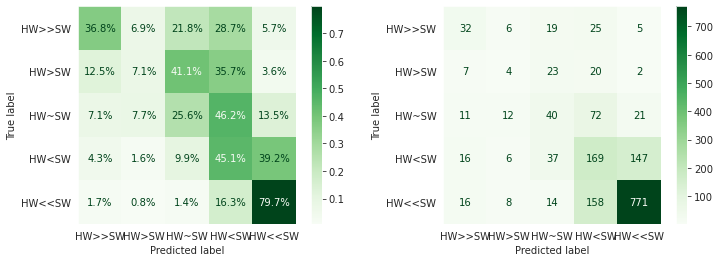

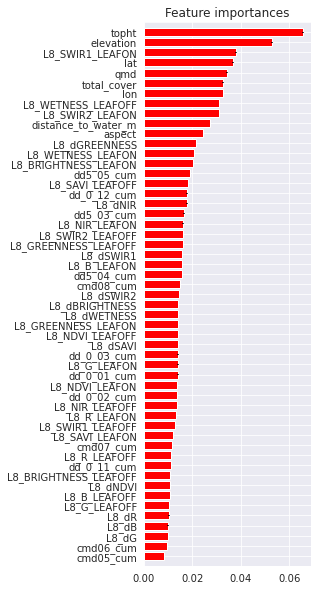

In [37]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'rf' 

TARGET_NAMES = ['HW>>SW', 'HW>SW', 'HW~SW', 'HW<SW', 'HW<<SW']
LABELS = [0, 1, 2, 3, 4]
spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                           target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [38]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'rf' 
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=[0, 1, 2, 3, 4], 
                  weights='linear')

0.4684331377873212

Running 200 rounds of cross-validation.
Sampling 2 parameters 100 times each.
Displaying best cross-validation scores... 
 0.212  0.323  0.397 .................Done. 
Model saved at ../models/composition/sklearn_tuned/HARDWOOD_SOFTWOOD_svc_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     HW>>SW       0.29      0.33      0.95      0.31      0.56      0.30        87
      HW>SW       0.11      0.23      0.93      0.15      0.47      0.20        56
      HW~SW       0.23      0.35      0.88      0.27      0.55      0.29       156
      HW<SW       0.38      0.43      0.80      0.40      0.58      0.33       375
     HW<<SW       0.86      0.68      0.84      0.76      0.76      0.57       967

avg / total       0.64      0.56      0.84      0.59      0.68      0.46      1641



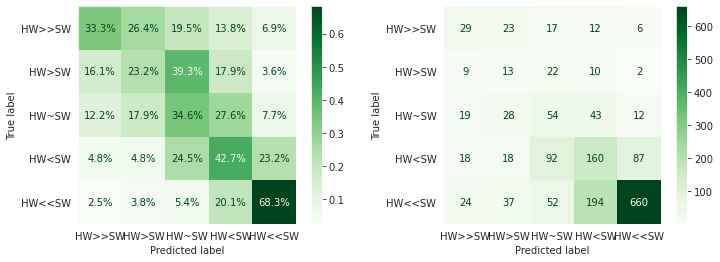

In [39]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'svc' 

TARGET_NAMES = ['HW>>SW', 'HW>SW', 'HW~SW', 'HW<SW', 'HW<<SW']
LABELS = [0, 1, 2, 3, 4]
spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=100,
                                                n_jobs=-1, n_points=5)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                           target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)

In [40]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'svc' 
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=[0, 1, 2, 3, 4], 
                  weights='linear')

0.43602564131095856

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.496 .... 0.500 ....
@ sample iteration 11
 0.501 .........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/DOUGLAS_FIR_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.63      0.62      0.88      0.62      0.74      0.53       394
    present       0.34      0.25      0.90      0.29      0.48      0.21       267
   abundant       0.30      0.24      0.89      0.26      0.46      0.19       285
   dominant       0.67      0.80      0.71      0.73      0.76      0.58       695

avg / total       0.54      0.57      0.81      0.55      0.65      0.44      1641



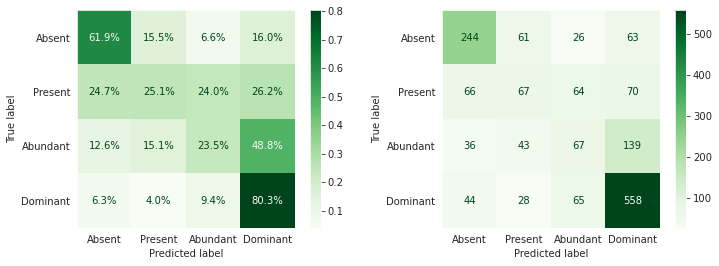

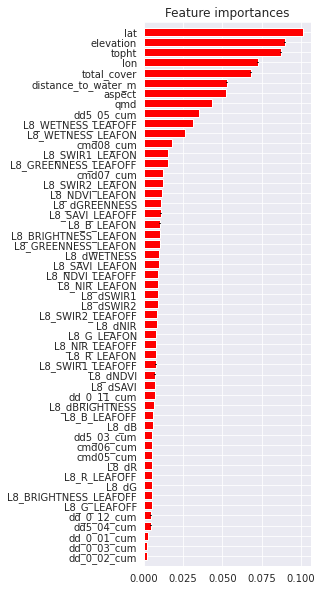

In [41]:
SP_NAME, MOD_TYPE = 'DOUGLAS_FIR', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.465 .. 0.473 . 0.479 ....
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/HEMLOCK_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.81      0.84      0.78      0.82      0.81      0.66       868
    present       0.53      0.51      0.80      0.52      0.64      0.40       495
   abundant       0.35      0.34      0.93      0.34      0.56      0.29       170
   dominant       0.32      0.31      0.95      0.32      0.55      0.28       108

avg / total       0.65      0.65      0.81      0.65      0.71      0.52      1641



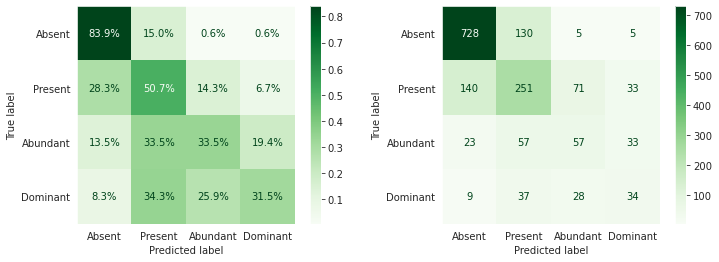

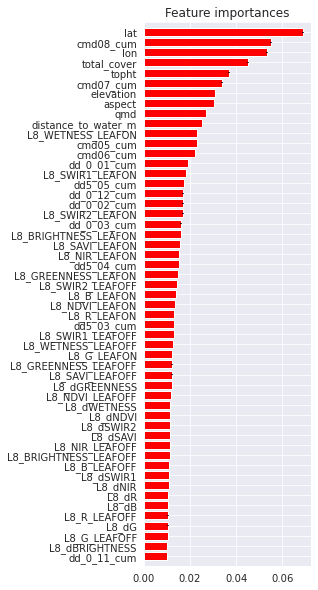

In [42]:
SP_NAME, MOD_TYPE = 'HEMLOCK', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.423 . 0.434 .......
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/RED_ALDER_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.83      0.81      0.62      0.82      0.71      0.52      1141
    present       0.32      0.36      0.80      0.34      0.54      0.28       337
   abundant       0.22      0.15      0.97      0.18      0.38      0.13        81
   dominant       0.25      0.28      0.96      0.26      0.52      0.25        82

avg / total       0.67      0.66      0.69      0.66      0.65      0.44      1641



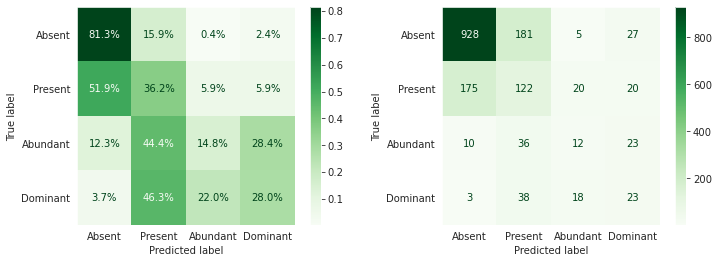

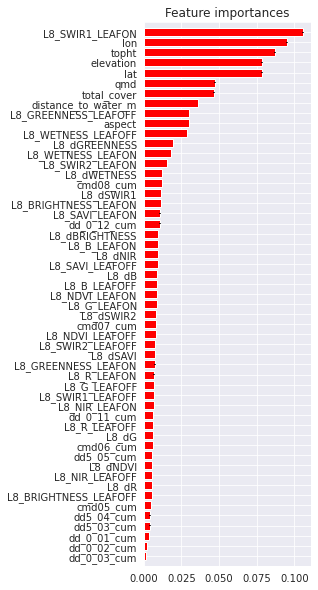

In [43]:
SP_NAME, MOD_TYPE = 'RED_ALDER', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.259 ... 0.262 .....
@ sample iteration 11
..... 0.267 ....
@ sample iteration 21
 0.268 ....Done. 
Model saved at ../models/composition/sklearn_tuned/CEDAR_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.83      0.83      0.43      0.83      0.59      0.37      1266
    present       0.27      0.35      0.81      0.31      0.53      0.27       274
   abundant       0.25      0.08      0.99      0.12      0.28      0.07        78
   dominant       0.60      0.13      1.00      0.21      0.36      0.12        23

avg / total       0.71      0.70      0.53      0.70      0.57      0.33      1641



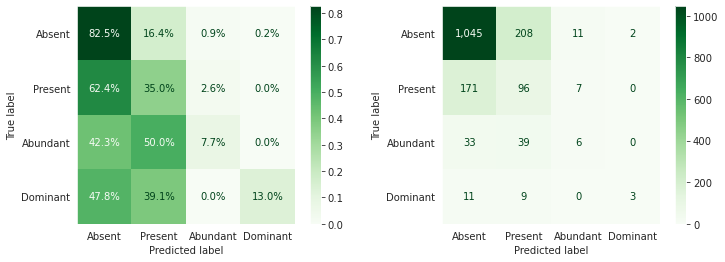

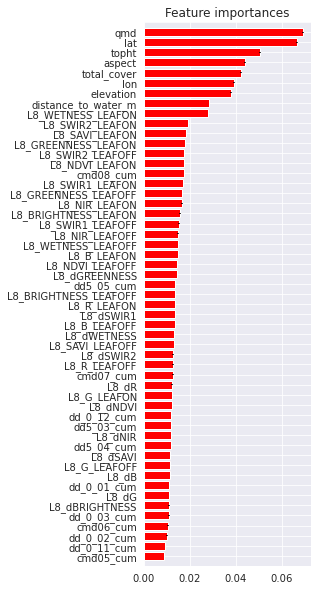

In [44]:
SP_NAME, MOD_TYPE = 'CEDAR', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.524 .. 0.529 . 0.550 ....
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/MAPLE_rf_tuned.pkl



/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

     absent       0.97      0.94      0.73      0.95      0.83      0.70      1474
    present       0.52      0.73      0.93      0.61      0.82      0.66       150
   abundant       0.00      0.00      1.00      0.00      0.00      0.00        10
   dominant       0.00      0.00      1.00      0.00      0.00      0.00         7

avg / total       0.92      0.91      0.75      0.91      0.82      0.69      1641



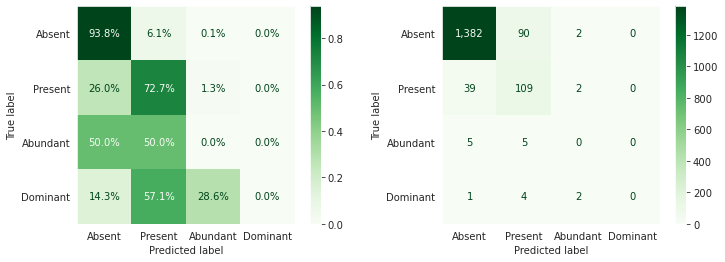

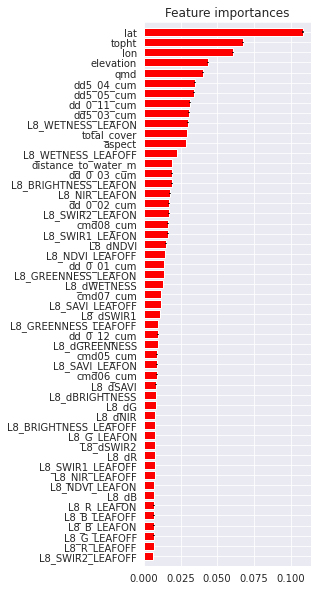

In [45]:
SP_NAME, MOD_TYPE = 'MAPLE', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.529 .........
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/TRUE_FIR_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.94      0.92      0.76      0.93      0.83      0.71      1302
    present       0.37      0.31      0.92      0.33      0.53      0.26       213
   abundant       0.15      0.15      0.96      0.15      0.38      0.13        81
   dominant       0.19      0.44      0.95      0.27      0.65      0.40        45

avg / total       0.80      0.79      0.79      0.79      0.77      0.61      1641



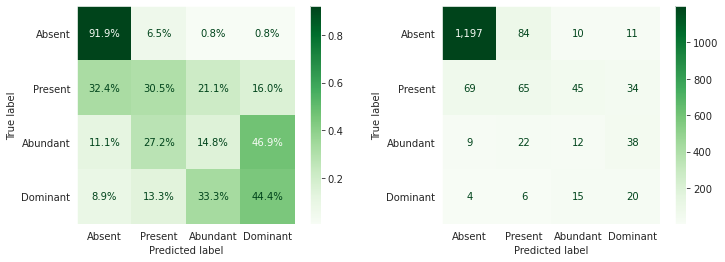

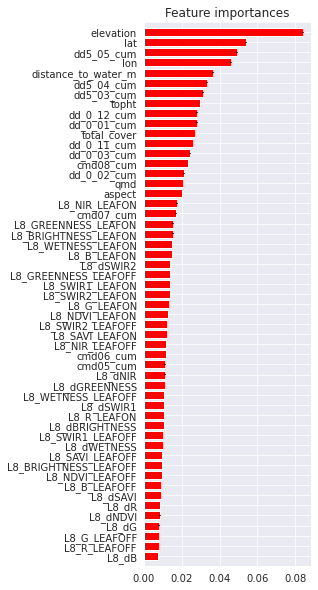

In [46]:
SP_NAME, MOD_TYPE = 'TRUE_FIR', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.553 ... 0.553  0.555  0.574 ...
@ sample iteration 11
..........
@ sample iteration 21
. 0.575 ...Done. 
Model saved at ../models/composition/sklearn_tuned/PONDEROSA_PINE_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.98      0.97      0.73      0.97      0.84      0.73      1517
    present       0.64      0.30      0.99      0.41      0.55      0.28        60
   abundant       0.18      0.15      0.99      0.16      0.38      0.13        27
   dominant       0.33      0.76      0.96      0.46      0.85      0.71        37

avg / total       0.94      0.93      0.75      0.93      0.83      0.70      1641



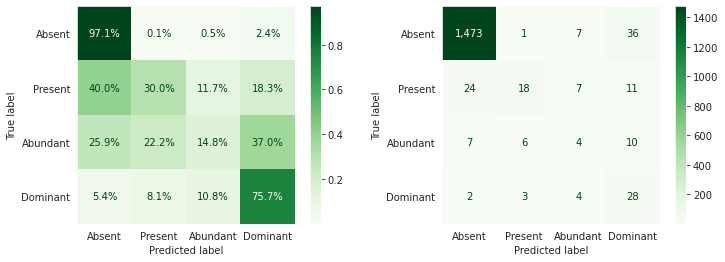

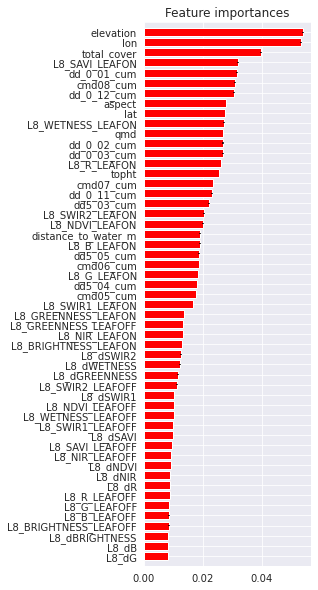

In [47]:
SP_NAME, MOD_TYPE = 'PONDEROSA_PINE', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.382 ... 0.390 .....
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/LODGEPOLE_PINE_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.99      0.97      0.64      0.98      0.79      0.64      1588
    present       0.25      0.49      0.96      0.33      0.69      0.45        41
   abundant       0.00      0.00      1.00      0.00      0.00      0.00         6
   dominant       0.33      0.33      1.00      0.33      0.58      0.31         6

avg / total       0.96      0.95      0.65      0.95      0.78      0.63      1641



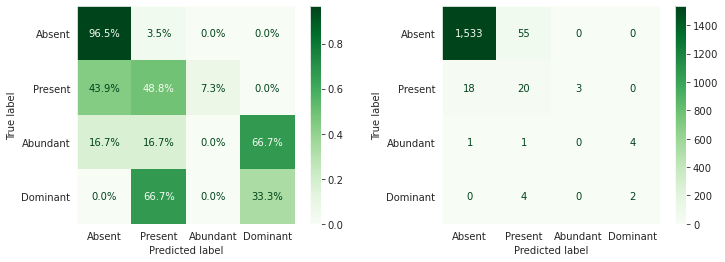

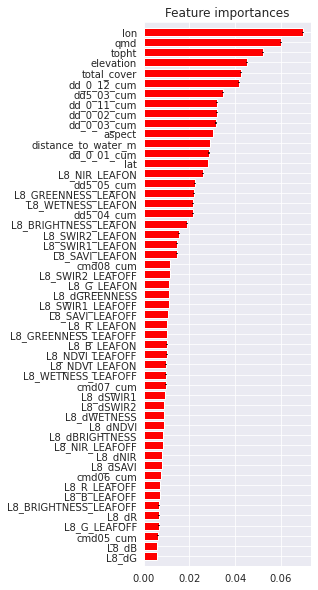

In [48]:
SP_NAME, MOD_TYPE = 'LODGEPOLE_PINE', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.406  0.430  0.432 .... 0.462 ..
@ sample iteration 11
...... 0.468 . 0.468  0.468 
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/OAK_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.99      0.98      0.69      0.99      0.82      0.69      1593
    present       0.48      0.69      0.98      0.57      0.82      0.66        45
   abundant       0.00      0.00      1.00      0.00      0.00      0.00         1
   dominant       0.00      0.00      1.00      0.00      0.00      0.00         2

avg / total       0.97      0.97      0.70      0.97      0.82      0.69      1641



/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


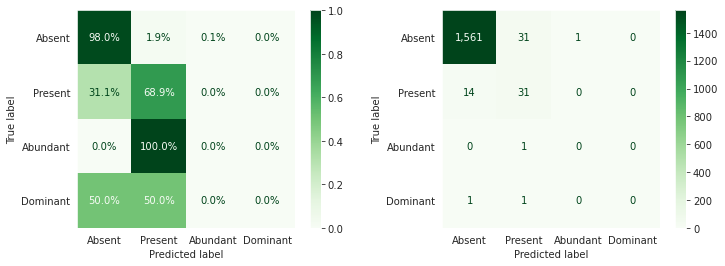

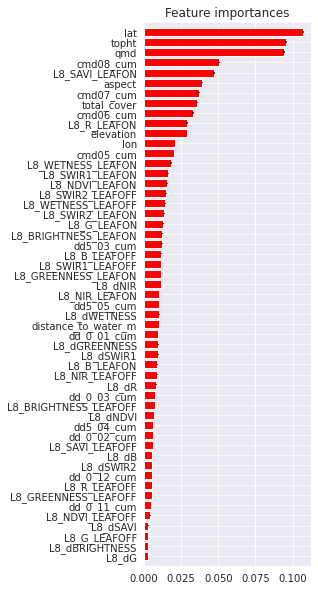

In [49]:
SP_NAME, MOD_TYPE = 'OAK', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.482  0.552  0.562 .... 0.593 ..
@ sample iteration 11
.. 0.623  0.644  0.644 . 0.666 . 0.675 .
@ sample iteration 21
... 0.675 .Done. 
Model saved at ../models/composition/sklearn_tuned/JUNIPER_rf_tuned.pkl



/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

     absent       1.00      1.00      0.44      1.00      0.67      0.47      1632
    present       1.00      0.33      1.00      0.50      0.58      0.31         9
   abundant       0.00      0.00      1.00      0.00      0.00      0.00         0

avg / total       1.00      1.00      0.45      1.00      0.67      0.47      1641



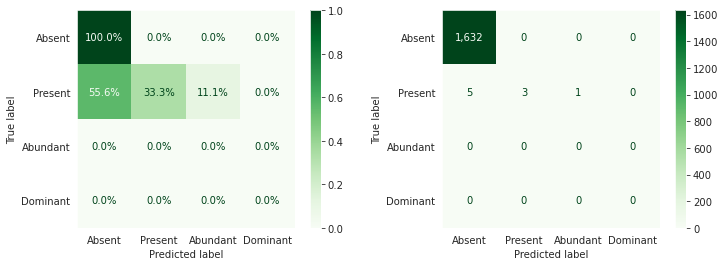

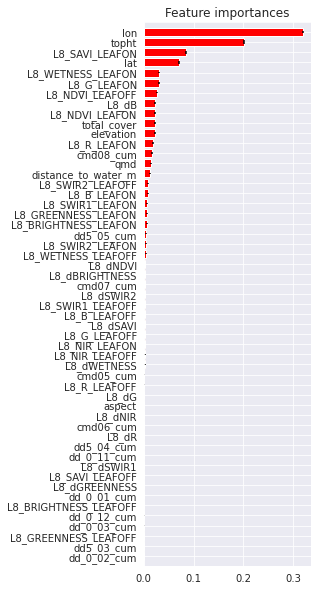

In [50]:
SP_NAME, MOD_TYPE = 'JUNIPER', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.296  0.375 ........
@ sample iteration 11
..........
@ sample iteration 21
 0.387 ....Done. 
Model saved at ../models/composition/sklearn_tuned/SPRUCE_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.98      0.94      0.71      0.96      0.82      0.69      1530
    present       0.35      0.54      0.95      0.42      0.72      0.49        76
   abundant       0.06      0.10      0.98      0.07      0.31      0.09        20
   dominant       0.20      0.20      0.99      0.20      0.45      0.18        15

avg / total       0.93      0.91      0.73      0.92      0.80      0.67      1641



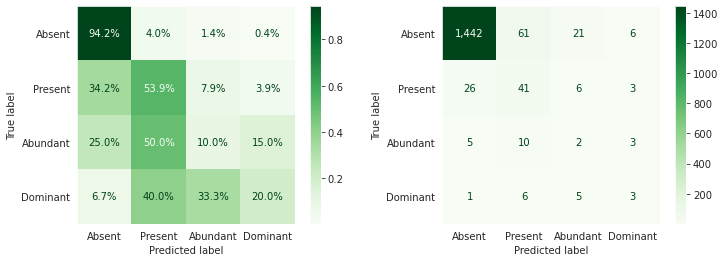

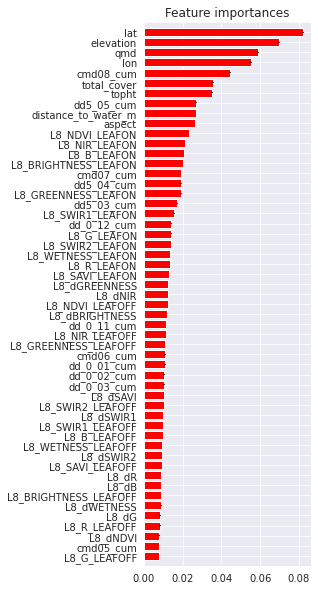

In [51]:
SP_NAME, MOD_TYPE = 'SPRUCE', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.464 . 0.508 . 0.514 .... 0.520 
@ sample iteration 11
........ 0.522 .
@ sample iteration 21
... 0.532 .Done. 
Model saved at ../models/composition/sklearn_tuned/TANOAK_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.99      0.99      0.73      0.99      0.85      0.74      1589
    present       0.59      0.57      0.99      0.58      0.75      0.55        40
   abundant       0.31      0.33      0.99      0.32      0.58      0.31        12

avg / total       0.98      0.98      0.74      0.98      0.85      0.74      1641



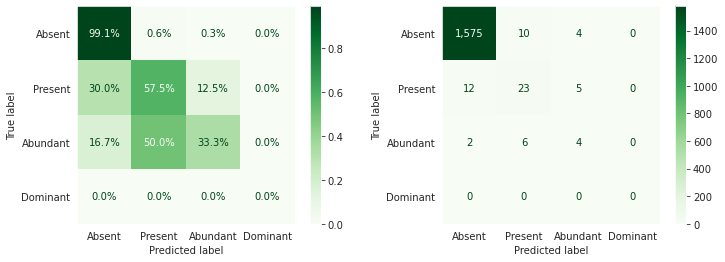

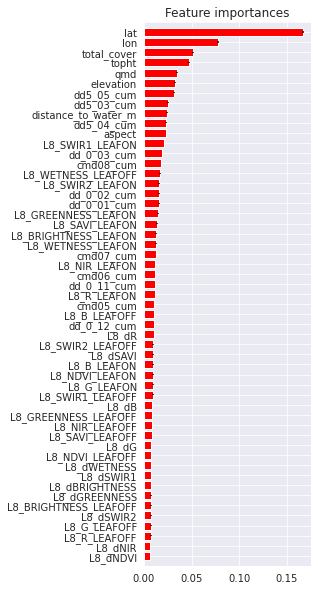

In [52]:
SP_NAME, MOD_TYPE = 'TANOAK', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.412 .... 0.419 ....
@ sample iteration 11
.... 0.424 .....
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/LARCH_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.98      0.97      0.65      0.98      0.80      0.66      1563
    present       0.28      0.69      0.96      0.40      0.81      0.64        35
   abundant       0.10      0.05      0.99      0.06      0.21      0.04        22
   dominant       0.00      0.00      1.00      0.00      0.00      0.00        21

avg / total       0.94      0.94      0.67      0.94      0.78      0.64      1641



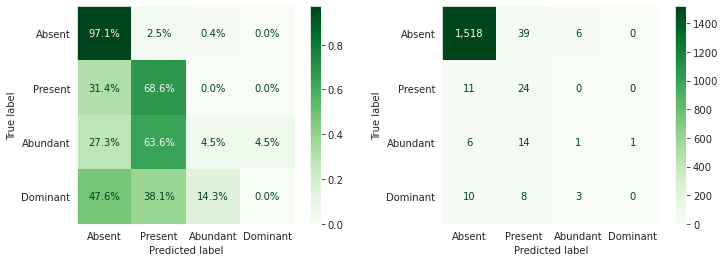

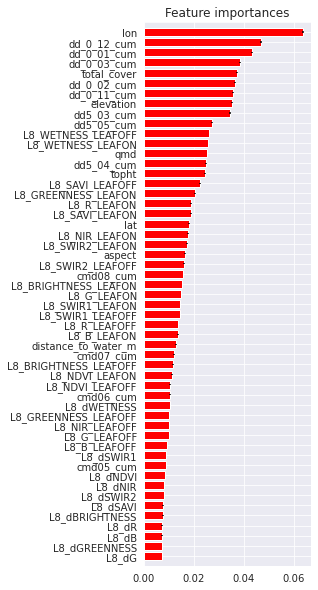

In [53]:
SP_NAME, MOD_TYPE = 'LARCH', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.279  0.297 ........
@ sample iteration 11
..... 0.308 ....
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/OTHER_HARDWOOD_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.88      0.80      0.66      0.84      0.73      0.53      1250
    present       0.40      0.55      0.81      0.46      0.67      0.43       305
   abundant       0.15      0.12      0.98      0.13      0.34      0.11        59
   dominant       0.21      0.37      0.98      0.27      0.60      0.34        27

avg / total       0.76      0.72      0.71      0.73      0.70      0.50      1641



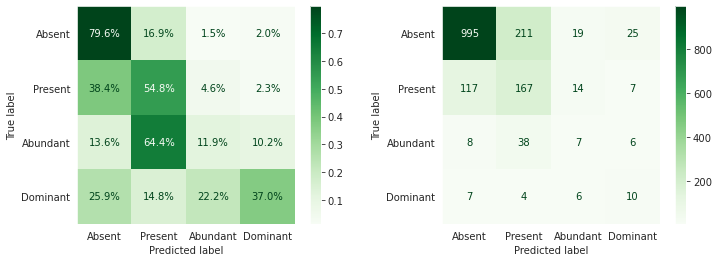

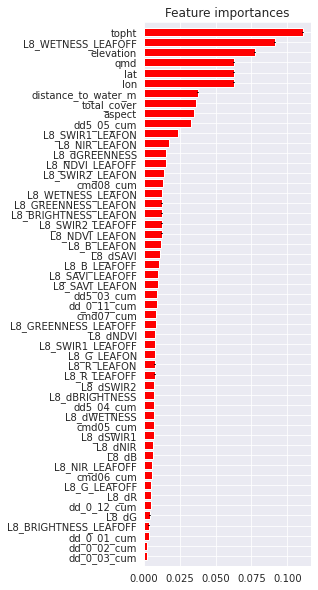

In [54]:
SP_NAME, MOD_TYPE = 'OTHER_HARDWOOD', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.126 ... 0.133 .. 0.175  0.180 .
@ sample iteration 11
. 0.188 ........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/OTHER_SOFTWOOD_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.98      0.90      0.56      0.94      0.71      0.52      1559
    present       0.24      0.56      0.91      0.33      0.71      0.49        82
   abundant       0.00      0.00      1.00      0.00      0.00      0.00         0

avg / total       0.94      0.89      0.58      0.91      0.71      0.52      1641



/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


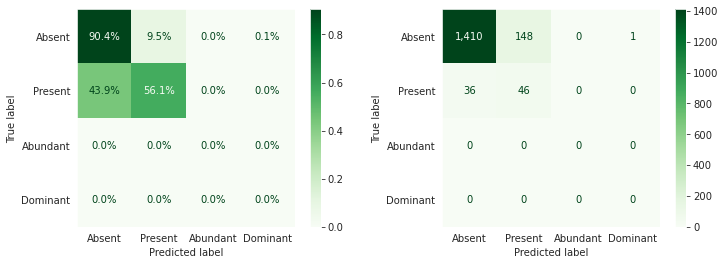

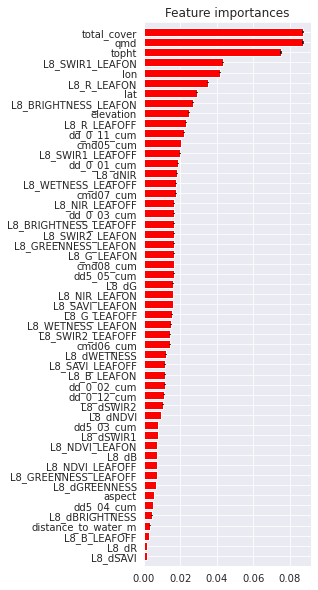

In [55]:
SP_NAME, MOD_TYPE = 'OTHER_SOFTWOOD', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])